In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# 1. Prepare data for modeling

In [5]:
model_df = pd.read_csv('model_dataset/labeled_processed_data.csv')
model_df['class'] = 'none'
model_df.loc[model_df['scratch'] == 1, 'class'] = 'scratch'
model_df.loc[model_df['focus_spot'] == 1, 'class'] = 'focus_spot'
model_df.drop(columns=['LOT_ID', 'WAFER_ID', 'WAFER_SCRIBE_ID',
                       'c_id', 'none', 'scratch', 'focus_spot'], inplace=True)

X = model_df.drop(columns='class')
y = model_df['class']
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.3,
                                                    random_state=11)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val,
                                                    stratify=y_test_val, 
                                                    test_size=0.5,
                                                    random_state=11)
X_train = pd.concat((X_train, X_val))
y_train = pd.concat((y_train, y_val))

# 2. Hyperparameter tuning for Random Forest

## Evaluate without weighting

In [26]:
clf = RandomForestClassifier(n_estimators=100,
                             n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)
print('Mean F1-Score: {:.2f}%'.format(np.mean(scores)*100))

Mean F1-Score: 70.36%


## Evaluate with class weighting

In [27]:
clf = RandomForestClassifier(n_estimators=100, 
                             class_weight='balanced', 
                             n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)
print('Mean F1-Score: {:.2f}%'.format(np.mean(scores)*100))

Mean F1-Score: 70.44%


## Evaluate with bootstrap class weighting

In [28]:
clf = RandomForestClassifier(n_estimators=100, 
                             class_weight='balanced_subsample',
                             n_jobs=-1)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)
print('Mean F1-Score: {:.2f}%'.format(np.mean(scores)*100))

Mean F1-Score: 70.55%


## Evaluate with random undersampling

In [24]:
clf = BalancedRandomForestClassifier(n_estimators=100)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)
print('Mean F1-Score: {:.2f}%'.format(np.mean(scores)*100))

Mean F1-Score: 65.66%


## Implement grid search on other hyperparameters

In [33]:
clf = RandomForestClassifier(n_estimators=100, 
                             class_weight='balanced_subsample',
                             n_jobs=-1)

# Show parameters
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [34]:
# Create grid of hyperparameters
bootstrap = [True, False]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in range(80, 120, 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
n_estimators = [int(x) for x in range(100, 1000, 100)]

grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

In [44]:
random_search = RandomizedSearchCV(estimator=clf, param_distributions=grid,
                         cv=5, n_jobs=-1, verbose=2)

In [46]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    n_jobs=-1),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [80, 90, 100, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900]},
                   verbose=2)

In [49]:
random_search.best_params_

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': False}

In [51]:
best_random = random_search.best_estimator_

In [53]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=2)
scores = cross_val_score(best_random, X_train, y_train, scoring='f1_macro',
                         cv=cv, n_jobs=-1)
print('Mean F1-Score: {:.2f}%'.format(np.mean(scores)*100))

Mean F1-Score: 72.72%


# 3. Evaluate Random Forest with chosen hyperparameters

              precision    recall  f1-score   support

  focus_spot       0.81      0.85      0.83       144
        none       0.95      0.95      0.95       505
     scratch       0.56      0.41      0.47        34

    accuracy                           0.90       683
   macro avg       0.77      0.74      0.75       683
weighted avg       0.90      0.90      0.90       683



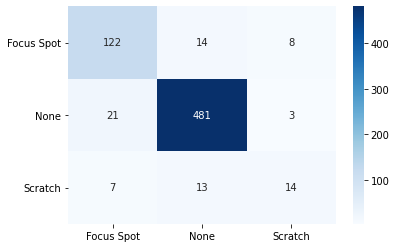

In [54]:
clf = RandomForestClassifier(n_estimators=700,
                             class_weight='balanced_subsample',
                             min_samples_split=5,
                             min_samples_leaf=1,
                             max_features='auto',
                             max_depth=None,
                             bootstrap=False)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)
print(classification_report(y_test, y_test_pred))
cf_matrix = confusion_matrix(y_test, y_test_pred)
labels = np.asarray(cf_matrix.flatten()).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',
            xticklabels=['Focus Spot', 'None', 'Scratch'],
            yticklabels=['Focus Spot', 'None', 'Scratch'])
plt.yticks(rotation=0)
plt.show()